In [1]:
import csv
from datetime import datetime
import pandas as pd
import numpy as np
from scipy import signal
from scipy.optimize import leastsq

import matplotlib.pyplot as plt 
# from scipy.fft import fft, fftfreq

import seaborn as sns

In [2]:
df = pd.read_csv('events/normal_breathing_1.csv')
df_temp = df.where(df['type'] == 'temperature').dropna().sort_values(by=['datetime'], ascending=True)
df_pressure = df.where(df['type'] == 'pressure').dropna().sort_values(by=['datetime'], ascending=True)
df_temp.head()

,Unnamed: 0,id,value,date,type,event_id,event_type,datetime
2517,2517.0,743.0,27.7,2021-02-04T17:03:55.607Z,temperature,1.0,normal_breathing,2021-02-04 17:03:55.607
2515,2515.0,742.0,27.7,2021-02-04T17:03:55.651Z,temperature,1.0,normal_breathing,2021-02-04 17:03:55.651
2513,2513.0,741.0,27.7,2021-02-04T17:03:55.695Z,temperature,1.0,normal_breathing,2021-02-04 17:03:55.695
2511,2511.0,740.0,27.7,2021-02-04T17:03:55.739Z,temperature,1.0,normal_breathing,2021-02-04 17:03:55.739
2509,2509.0,739.0,27.7,2021-02-04T17:03:55.783Z,temperature,1.0,normal_breathing,2021-02-04 17:03:55.783


In [3]:
# filter design
def lp_filter(cutoff, sig, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='lowpass')
    y = signal.lfilter(b, a, sig)
    return y

def difference_transform(sig, interval=1):
    diff = []
    for i in range(interval, len(sig)-1):
        val = sig[i] - sig[i+1]
        diff.append(val)
    return np.array(diff) 

def demean(sig):
    mean = sig.mean()
    return sig - mean


In [ ]:
def get_respiration_rate(df):
    y = df['values'].to_numpy()
    x = np.array(range(len(y)))
    
    # polyfit
    poly_model = np.poly1d(np.polyfit(x, y, 2))
    fit_y = y-model(x)

    # low pass filter
    filtered_y = lp_filter(2,fit_y,25)

    # zero crossing indices
    zero_crossings = np.where(np.diff(np.sign(filtered_y)))[0]
    
    # calc resp rate
    zero_crossing_records = df_temp.iloc[zero_crossings]

    date_format = '%Y-%m-%d %H:%M:%S.%f'

    rates = []

    for i in range(0, len(zero_crossing_records)-2, 1):
        start = datetime.strptime(zero_crossing_records.iloc[i][-1], date_format)
        end = datetime.strptime(zero_crossing_records.iloc[i+2][-1], date_format)
        rates.append(end-start)

    resp_rate = 60.0 / np.mean(rates).total_seconds()
    
    return resp_rate



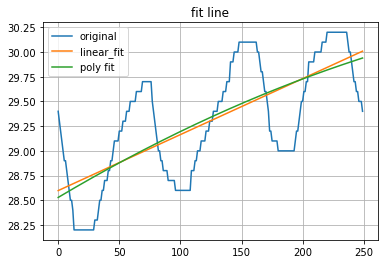

In [4]:
# find linear trend
def linear_fit(x, y):
    # y = a + bX
    
    # b
    x_hat = np.mean(x)
    y_hat = np.mean(y)
    b = ( np.sum((x-x_hat) * (y-y_hat)) ) / np.sum((x-x_hat)**2) 

    # a
    a = y_hat - (b*x_hat)

    return a, b

y = df_temp['value'].to_numpy()[250:500]
x = np.array(range(len(y)))
a, b = linear_fit(x,y)

model = np.poly1d(np.polyfit(x, y, 2))

plt.plot(x, y, label='original')
plt.plot(x, a+b*x, label='linear_fit')
plt.plot(x, model(x), label='poly fit')
plt.title("fit line")
plt.grid()
plt.legend()
plt.show()


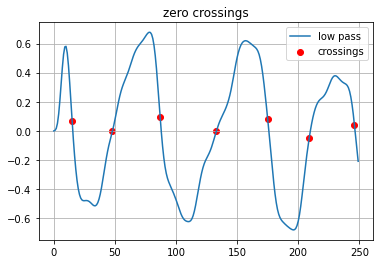

In [5]:
# fit_y = y-(a+x*b)
fit_y = y-model(x)
filtered_y = lp_filter(2,fit_y,25)

zero_crossings = np.where(
    np.diff(
        np.sign(filtered_y)
        )
    )[0]

plt.plot(x, filtered_y, label='low pass')
plt.scatter(x[zero_crossings], filtered_y[zero_crossings], label='crossings', c='red')

plt.title('zero crossings')
plt.grid()
plt.legend()
# plt.xlim([230, 250])
plt.show()

In [12]:
# calc respiration rate.
zero_crossing_records = df_temp.iloc[zero_crossings]

date_format = '%Y-%m-%d %H:%M:%S.%f'

rates = []

for i in range(0, len(zero_crossing_records)-2, 1):
    start = datetime.strptime(zero_crossing_records.iloc[i][-1], date_format)
    end = datetime.strptime(zero_crossing_records.iloc[i+2][-1], date_format)
    rates.append(end-start)

resp_rate = 60.0 / np.mean(rates).total_seconds()
print(f'respiration_rate: {resp_rate}')
    

respiration_rate: 17.40644038294169
